<a href="https://colab.research.google.com/github/TCassano/AIEngineeringMaster/blob/main/MLFoundations/progetto_corso_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerie e Moduli

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

## Imposto qualche funzione Helper che ho preso dal corso

In [9]:
def evaluate_model(model, dataset):
    X,y = dataset
    y_pred = model.predict(X)
    print (f"MSE: {mean_squared_error(y, y_pred):.3f}")
    print (f"R2: {r2_score(y, y_pred):.3f}")
    return mean_squared_error(y, y_pred), r2_score(y, y_pred)

In [10]:
def root_mean_squared_error(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

In [11]:
def plotting_residuals_with_rmse(model,ss_y,y_test, X_test_scaled):
    y_pred = ss_y.inverse_transform(np.array(model.predict(X_test_scaled)).reshape(-1, 1))
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(np.arange(len(residuals)), residuals, alpha=0.7)
    plt.axhline(root_mean_squared_error(y_test, y_pred), color='red', linestyle='--', label='RMSE')
    plt.axhline(-root_mean_squared_error(y_test, y_pred), color='red', linestyle='--')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Residuals vs Predicted Values with RMSE')
    plt.text(0, root_mean_squared_error(y_test, y_pred)+2000000, f'RMSE: {root_mean_squared_error(y_test, y_pred):.3f}', color='red')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.legend(("residuals","+RMSE","-RMSE","Mean"), loc='upper right', fontsize='small', frameon=True)
    plt.grid(True)
    plt.show()

In [12]:
def plotting_predict_vs_true_parity(model,ss_y,y_test, X_test_scaled):
    """
    Plots predicted vs true values for regression models. This plot is named "parity plot".
    """
    y_pred = ss_y.inverse_transform(np.array(model.predict(X_test_scaled)).reshape(-1, 1))
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Predicted vs True Values')
    plt.grid(True)
    plt.show()

In [13]:
def plotting_predict_vs_true(model,ss_y,y_test, X_test_scaled):
    """
    This plot is not a parity plot, because the parity plot should have a line y=x.
    """

    y_pred = ss_y.inverse_transform(np.array(model.predict(X_test_scaled)).reshape(-1, 1))
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(y_test)), y_test, label='True Values', alpha=0.7)
    plt.plot(np.arange(len(y_test)), y_pred, label='Predicted Values', alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Values')
    plt.title('True vs Predicted Values')
    plt.grid(True)
    plt.legend(("True Values","Predicted Values"), loc='upper right', fontsize='small', frameon=True)
    plt.show()

## Pre-processing dei dati

In [14]:
df = pd.read_csv('housing.csv')
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


In [15]:
for col in df.columns:
  print(f" Per la colonna {col} ci sono {df[col].isna().sum()} valori NaN")

 Per la colonna price ci sono 0 valori NaN
 Per la colonna area ci sono 0 valori NaN
 Per la colonna bedrooms ci sono 0 valori NaN
 Per la colonna bathrooms ci sono 0 valori NaN
 Per la colonna stories ci sono 0 valori NaN
 Per la colonna mainroad ci sono 0 valori NaN
 Per la colonna guestroom ci sono 0 valori NaN
 Per la colonna basement ci sono 0 valori NaN
 Per la colonna hotwaterheating ci sono 0 valori NaN
 Per la colonna airconditioning ci sono 0 valori NaN
 Per la colonna parking ci sono 0 valori NaN
 Per la colonna prefarea ci sono 0 valori NaN
 Per la colonna furnishingstatus ci sono 0 valori NaN


In [16]:
print("Tipi di dato per ogni colonna:")
print(df.dtypes)
print("Le colonne non hanno variabili categoriche, solo l'ultima colonna 'furnishingstatus' è di tipo object, ma in realtà contiene solo 3 valori distinti che rappresentano lo stato dell'arredamento della casa (furnished, semi-furnished, unfurnished), quindi possiamo considerarla come una variabile categorica. Devo fare OHE per questa colonna.")

Tipi di dato per ogni colonna:
price               int64
area                int64
bedrooms            int64
bathrooms           int64
stories             int64
mainroad            int64
guestroom           int64
basement            int64
hotwaterheating     int64
airconditioning     int64
parking             int64
prefarea            int64
furnishingstatus    int64
dtype: object
Le colonne non hanno variabili categoriche, solo l'ultima colonna 'furnishingstatus' è di tipo object, ma in realtà contiene solo 3 valori distinti che rappresentano lo stato dell'arredamento della casa (furnished, semi-furnished, unfurnished), quindi possiamo considerarla come una variabile categorica. Devo fare OHE per questa colonna.


In [17]:
categorical_features = ['furnishingstatus']
numeric_features = [col for col in df.columns if col not in categorical_features + ['price']]

# Costruisci il transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # lascia inalterate le numeriche
        ('cat', OneHotEncoder(), categorical_features)  # OHE sulla categorica
    ])

# Applica la trasformazione
X = preprocessor.fit_transform(df.drop('price', axis=1))
y = df['price']

X = pd.DataFrame(X, columns=numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))
y = pd.Series(y)

In [18]:
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
y_train = (y_train.values.reshape(-1, 1))
y_test = (y_test.values.reshape(-1, 1))

Visualizzazione del Dataset (EDA)

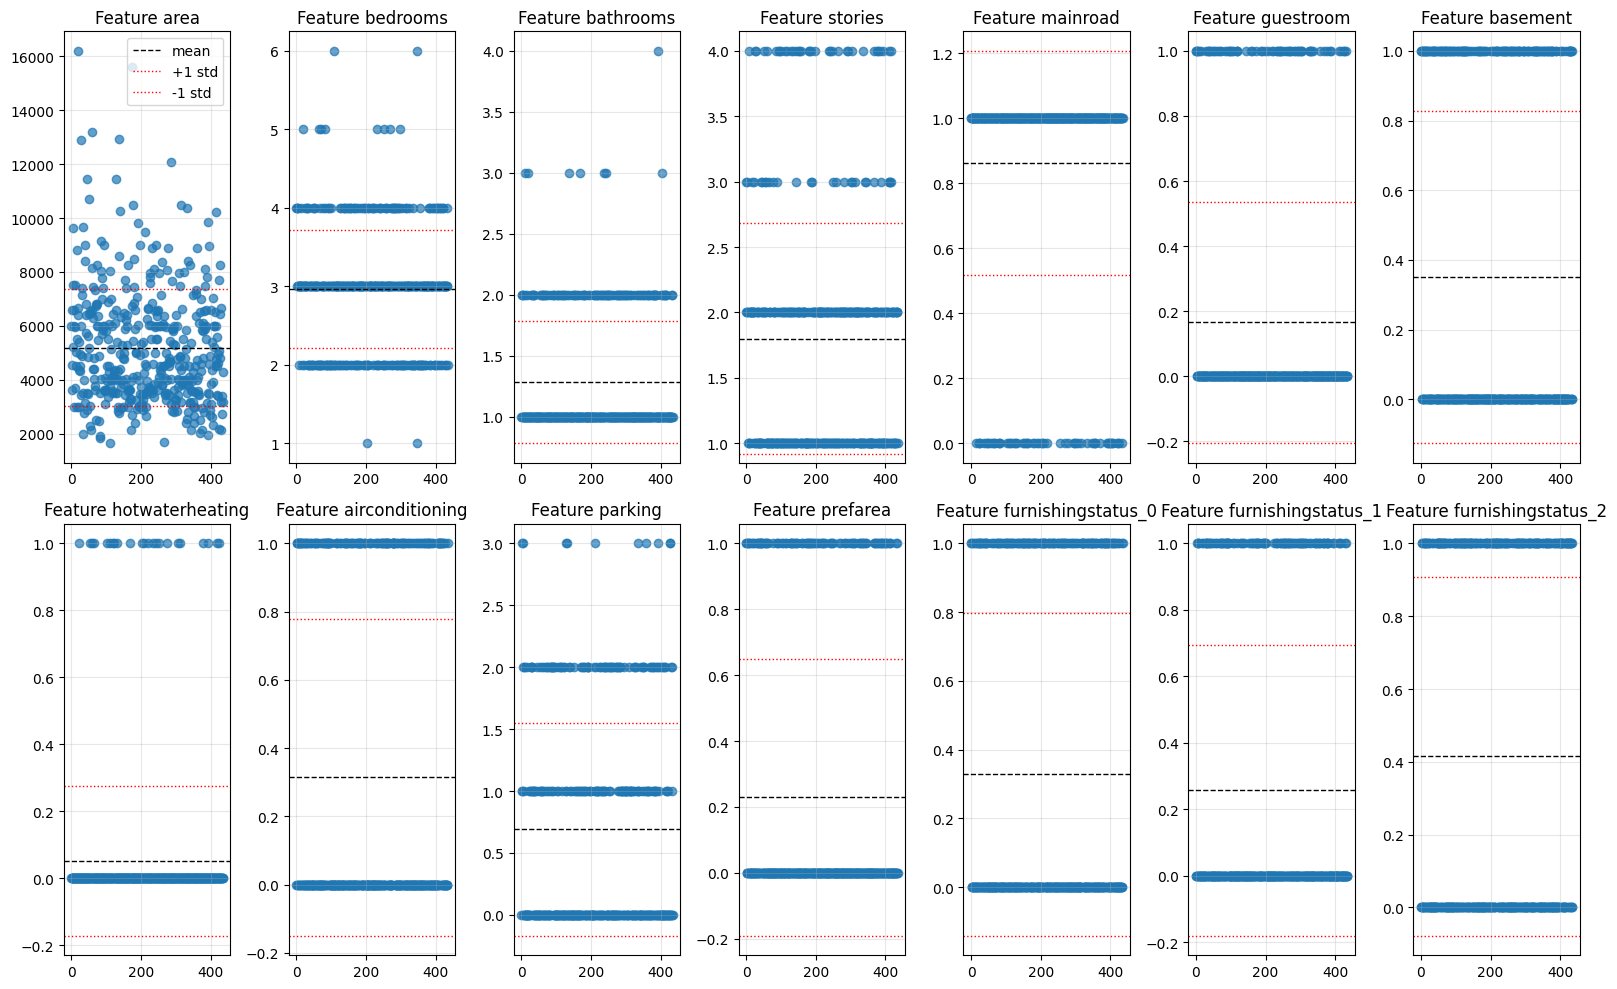

In [20]:
n_features = 14
fig, axes = plt.subplots(2, 7, figsize=(16, 10))
axes = axes.ravel()

feature_names = X_train.columns

for i, feature_name in enumerate(feature_names):
    data = X_train[feature_name]
    ax = axes[i]
    ax.scatter(np.arange(len(data)), data, alpha=0.7)

    mean = np.mean(data)
    std = np.std(data)

    ax.axhline(mean, color="black", linestyle="--", linewidth=1, label="mean")
    ax.axhline(mean + std, color="red", linestyle=":", linewidth=1, label="+1 std")
    ax.axhline(mean - std, color="red", linestyle=":", linewidth=1, label="-1 std")

    ax.set_title(f"Feature {feature_name}")
    ax.grid(True, alpha=0.3)

axes[0].legend()

plt.tight_layout()
plt.show()


Feature Scaling

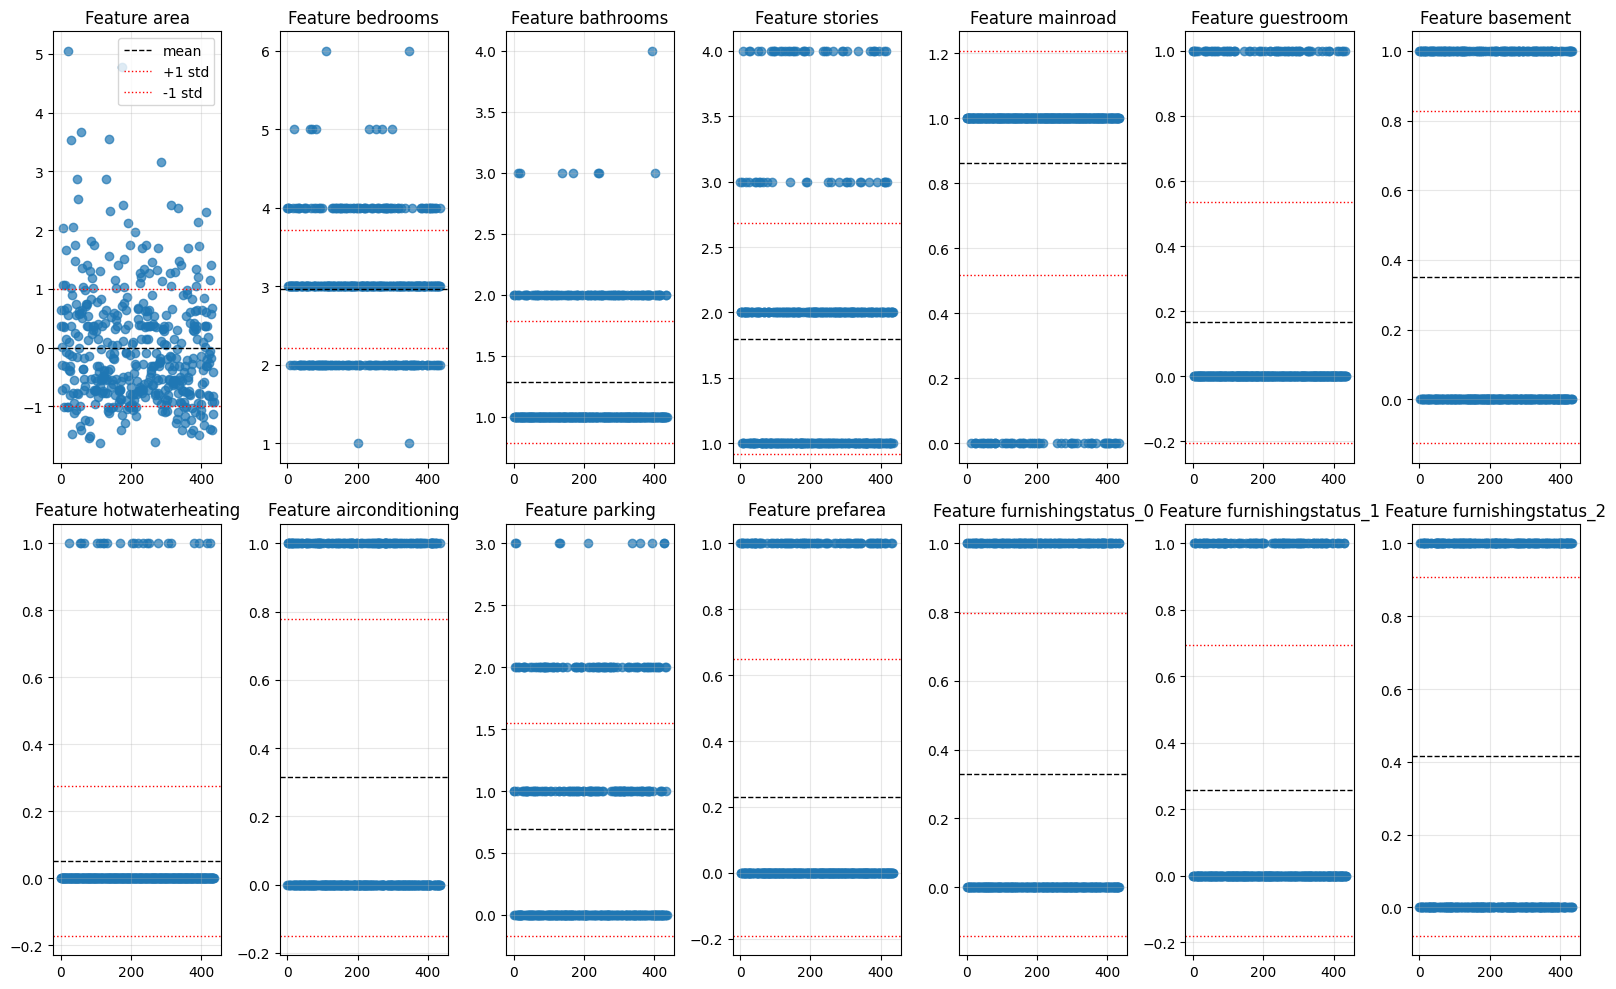

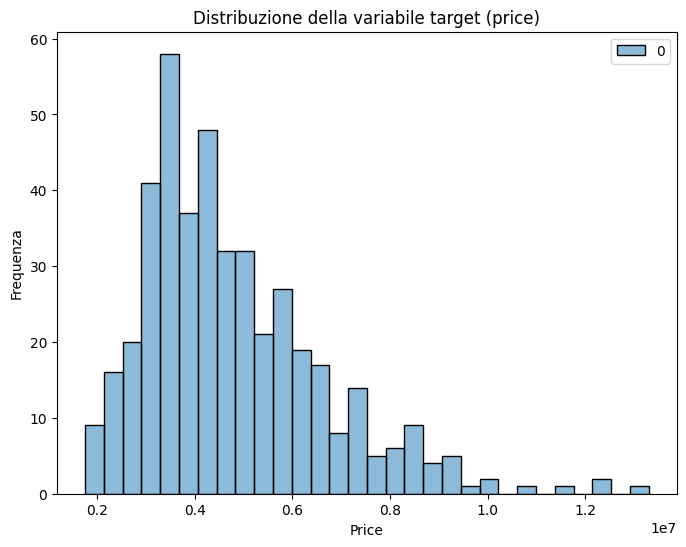

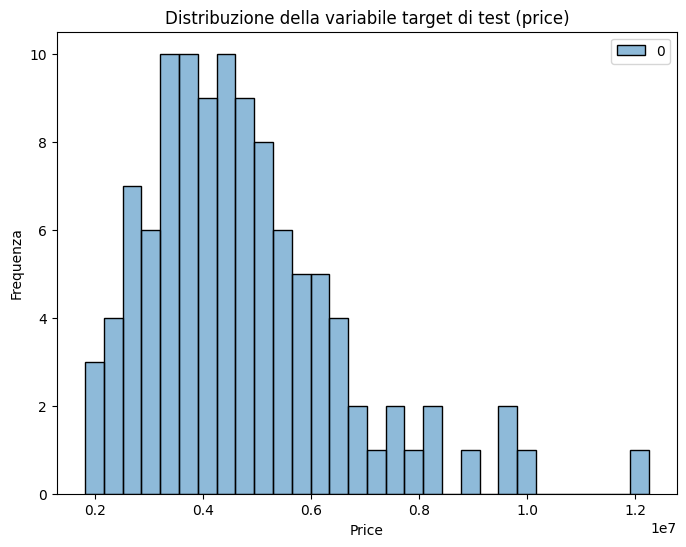

In [21]:
ss = StandardScaler() #preferisco applicare uno standard scaler, per non perdere informazioni sugli outlier
ss_y = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[['area']] = ss.fit_transform(X_train[['area']])
X_test_scaled[['area']] = ss.transform(X_test[['area']]) # preferisco andare a scalare solo l'area, che è la feature con la varianza più alta, ma sopratutto non vedo il senso di standardizzare feature discrete come bedrooms, bathrooms, stories, parking
# unico train e test per la cross validation
X_scaled = np.vstack((X_train_scaled, X_test_scaled))

y_train_scaled = ss_y.fit_transform(y_train)
y_test_scaled = ss_y.transform(y_test)

#unisco train e test per la cross validation
y_scaled = np.vstack((y_train_scaled, y_test_scaled))

## Visualizzazione delle feature dopo la standardizzazione
n_features = 13
fig, axes = plt.subplots(2, 7, figsize=(16, 10))
axes = axes.ravel()

for i, feature_name in enumerate(feature_names):
    data = X_train_scaled[feature_name]
    ax = axes[i]
    ax.scatter(np.arange(len(data)), data, alpha=0.7)

    mean = np.mean(data)
    std = np.std(data)

    ax.axhline(mean, color="black", linestyle="--", linewidth=1, label="mean")
    ax.axhline(mean + std, color="red", linestyle=":", linewidth=1, label="+1 std")
    ax.axhline(mean - std, color="red", linestyle=":", linewidth=1, label="-1 std")
    ax.set_title(f"Feature {feature_name}")
    ax.grid(True, alpha=0.3)

axes[0].legend()
plt.tight_layout()
plt.show()
#Visualizziamo la distribuzione della variabile target
plt.figure(figsize=(8, 6))
sns.histplot(y_train, bins=30)
plt.title('Distribuzione della variabile target (price)')
plt.xlabel('Price')
plt.ylabel('Frequenza')
plt.show()
# Visualizziamo la variabile di test
plt.figure(figsize=(8, 6))
sns.histplot(y_test, bins=30)
plt.title('Distribuzione della variabile target di test (price)')
plt.xlabel('Price')
plt.ylabel('Frequenza')
plt.show()


Allenamento dei modelli con il miglior LR

In [22]:
alpha_learning = 0.01 #Fissiamo il miglior learning rate (vd studio parametrico in fondo)

In [23]:
lasso = Lasso(alpha = alpha_learning)
lasso.fit(X_train_scaled, y_train_scaled)
print("Statistiche sul set di train:")
evaluate_model(lasso, (X_train_scaled, y_train_scaled))
print("Statistiche sul set di test:")
evaluate_model(lasso, (X_test_scaled, y_test_scaled))

Statistiche sul set di train:
MSE: 0.330
R2: 0.670
Statistiche sul set di test:
MSE: 0.307
R2: 0.697


(0.30673302023377047, 0.6973921798157753)

In [24]:
ridge = Ridge(alpha=alpha_learning)
ridge.fit(X_train_scaled, y_train_scaled)
print("Statistiche sul set di train:")
evaluate_model(ridge, (X_train_scaled, y_train_scaled))
print("Statistiche sul set di test:")
evaluate_model(ridge, (X_test_scaled, y_test_scaled))

Statistiche sul set di train:
MSE: 0.326
R2: 0.674
Statistiche sul set di test:
MSE: 0.304
R2: 0.700


(0.30365060928557264, 0.7004331359450999)

In [25]:
elastic = ElasticNet(alpha=alpha_learning, l1_ratio = 0.9)
elastic.fit(X_train_scaled, y_train_scaled)
print("Statistiche sul set di train:")
evaluate_model(elastic, (X_train_scaled, y_train_scaled))
print("Statistiche sul set di test:")
evaluate_model(elastic, (X_test_scaled, y_test_scaled))

Statistiche sul set di train:
MSE: 0.330
R2: 0.670
Statistiche sul set di test:
MSE: 0.306
R2: 0.698


(0.30620379535738435, 0.6979142872371036)

Vediamo i risultati di un modello elastic sui residui

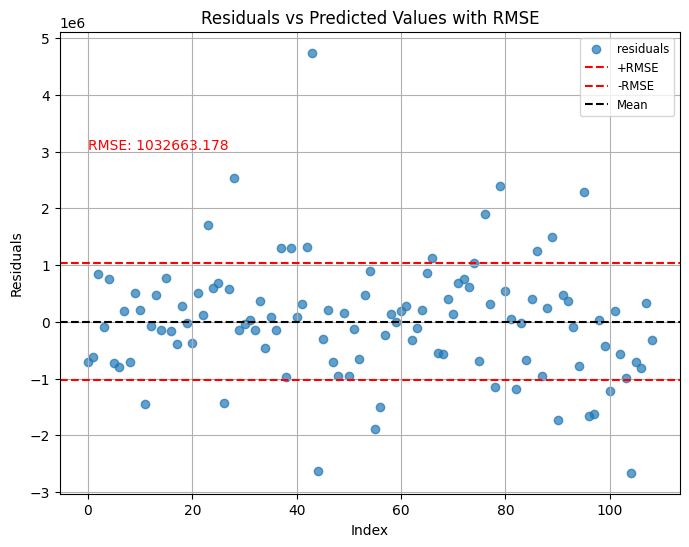

In [26]:
plotting_residuals_with_rmse(elastic,ss_y,y_test, X_test_scaled)

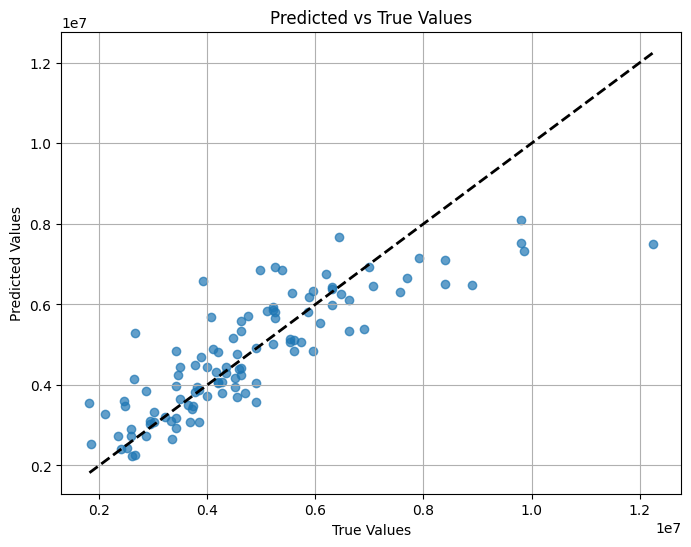

In [27]:
plotting_predict_vs_true_parity(elastic,ss_y,y_test, X_test_scaled)

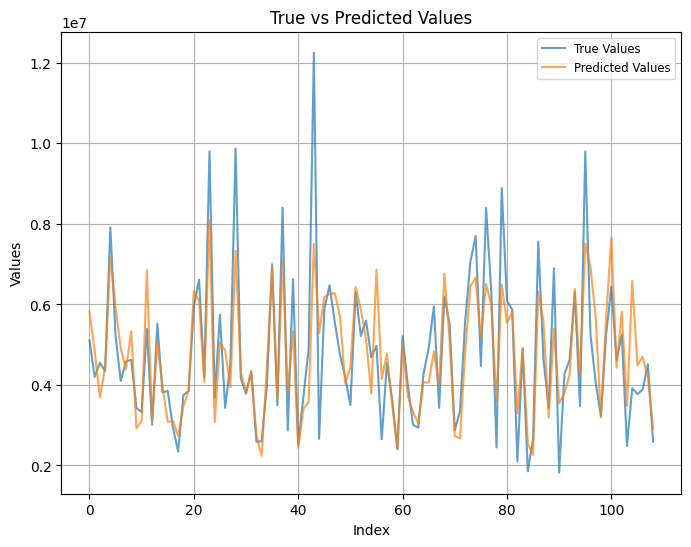

In [28]:
plotting_predict_vs_true(elastic,ss_y,y_test, X_test_scaled)

### Studio parametrico delle performance dei modelli di regressione Lasso e Ridge (Vario il LR)

Learning rate: 0.01
Lasso
Statistiche sul set di train:
MSE: 0.330
R2: 0.670
Statistiche sul set di test:
MSE: 0.307
R2: 0.697
Ridge
Statistiche sul set di train:
MSE: 0.326
R2: 0.674
Statistiche sul set di test:
MSE: 0.304
R2: 0.700
Learning rate: 0.02
Lasso
Statistiche sul set di train:
MSE: 0.344
R2: 0.656
Statistiche sul set di test:
MSE: 0.318
R2: 0.686
Ridge
Statistiche sul set di train:
MSE: 0.326
R2: 0.674
Statistiche sul set di test:
MSE: 0.304
R2: 0.700
Learning rate: 0.03
Lasso
Statistiche sul set di train:
MSE: 0.357
R2: 0.643
Statistiche sul set di test:
MSE: 0.329
R2: 0.675
Ridge
Statistiche sul set di train:
MSE: 0.326
R2: 0.674
Statistiche sul set di test:
MSE: 0.304
R2: 0.700
Learning rate: 0.04
Lasso
Statistiche sul set di train:
MSE: 0.372
R2: 0.628
Statistiche sul set di test:
MSE: 0.345
R2: 0.659
Ridge
Statistiche sul set di train:
MSE: 0.326
R2: 0.674
Statistiche sul set di test:
MSE: 0.304
R2: 0.700
Learning rate: 0.05
Lasso
Statistiche sul set di train:
MSE: 0.3

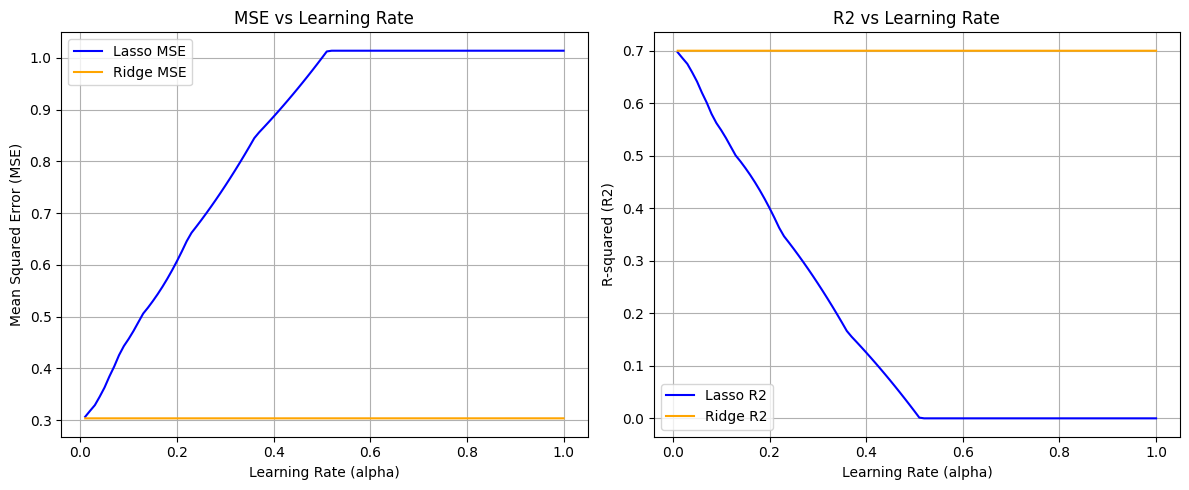

In [29]:
# Creo un vettore di learning rate da 0.01 a 1 con step di 0.01
learning_rates = [x * 0.01 for x in range(1, 101)]
#inizializzo le liste per salvare gli MSE e R2
mse_lasso = []
r2_lasso = []
mse_ridge = []
r2_ridge = []
# Imposto il ciclo for su tutti i learning rates
for alpha in learning_rates:
    print(f"Learning rate: {alpha}")
    lasso = Lasso(alpha = alpha)
    lasso.fit(X_train_scaled, y_train_scaled)
    print("Lasso")
    print("Statistiche sul set di train:")
    evaluate_model(lasso, (X_train_scaled, y_train_scaled))
    print("Statistiche sul set di test:")
    mse, r2 = evaluate_model(lasso, (X_test_scaled, y_test_scaled))
    mse_lasso.append(mse)
    r2_lasso.append(r2)

    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train_scaled)
    print("Ridge")
    print("Statistiche sul set di train:")
    evaluate_model(ridge, (X_train_scaled, y_train_scaled))
    print("Statistiche sul set di test:")
    mse, r2 = evaluate_model(ridge, (X_test_scaled, y_test_scaled))
    mse_ridge.append(mse)
    r2_ridge.append(r2)
# Visualizzo i risultati
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(learning_rates, mse_lasso, label='Lasso MSE', color='blue')
plt.plot(learning_rates, mse_ridge, label='Ridge MSE', color='orange')
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Learning Rate')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(learning_rates, r2_lasso, label='Lasso R2', color='blue')
plt.plot(learning_rates, r2_ridge, label='Ridge R2', color='orange')
plt.xlabel('Learning Rate (alpha)')
plt.ylabel('R-squared (R2)')
plt.title('R2 vs Learning Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Possiamo concludere che con questi modelli di regressione abbiamo le performance migliori (sul set di test) quando il learning rate è molto piccolo

Andiamo a fare cross validation a 5 fold

In [30]:
alpha_learning = 0.01
models = {
    "Ridge": Ridge(alpha=alpha_learning),
    "Lasso": Lasso(alpha=alpha_learning),
    "ElasticNet": ElasticNet(alpha=alpha_learning, l1_ratio=0.5)
}

results = {}

for name, model in models.items():
    mse_scores = -cross_val_score(model, X_scaled, y_scaled, cv=5, scoring="neg_mean_squared_error")
    r2_scores = cross_val_score(model, X_scaled, y_scaled, cv=5, scoring="r2")
    results[name] = {
        "MSE_mean": np.mean(mse_scores),
        "MSE_std": np.std(mse_scores),
        "R2_mean": np.mean(r2_scores),
        "R2_std": np.std(r2_scores)
    }



Contiamo gli zero coefficients per vedere la complessità dei vari modelli

In [31]:
for name, model in models.items():
    model.fit(X_scaled, y_scaled)
    n_nonzero = np.sum(model.coef_ != 0)
    results[name]["Non_zero_coefs"] = n_nonzero


In [32]:
df_results = pd.DataFrame(results).T[
    ["MSE_mean", "R2_mean", "Non_zero_coefs"]
].round(3)

print("Confronto modelli:")
print(df_results)

Confronto modelli:
            MSE_mean  R2_mean  Non_zero_coefs
Ridge          0.360    0.628            14.0
Lasso          0.367    0.622            12.0
ElasticNet     0.362    0.627            13.0


### Lasso è meno complesso di tutti, ridge + complesso mentre elastic è una via di mezzo, tenendo conto degli zero coefficients. Mentre la crossvalidation conferma i risultati sopra riportati.